In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, leastsq
import numpy as np
import pandas as pd

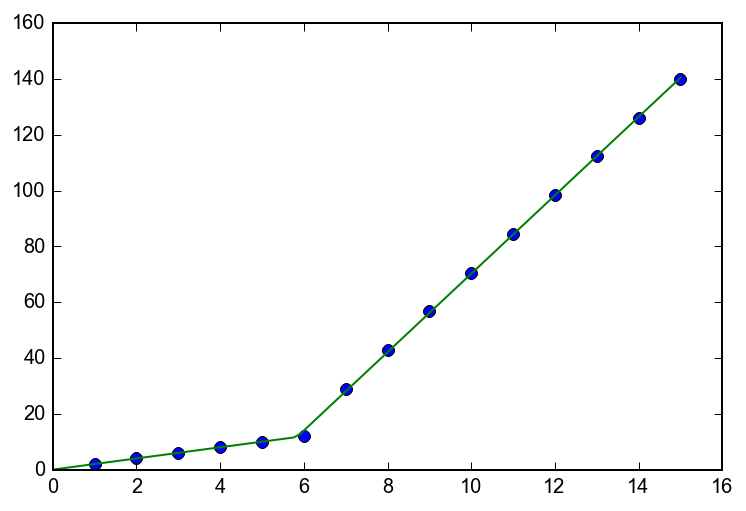

In [47]:
#p , e = curve_fit(piecewise_linear_2, x, y)
#xd = np.linspace(0, 15, 100)
#plt.plot(x, y, "o")
#plt.plot(xd, piecewise_linear_2(xd, *p))

In [3]:
import sys; sys.path.append('../slip_rate_tools')
import slip_rate_tools as srt

In [4]:
from importlib import reload

In [15]:
reload(srt)

<module 'slip_rate_tools' from '../slip_rate_tools/slip_rate_tools.py'>

In [5]:
xd = np.array([   0.        ,   27.18180895,   74.1173085 ,  333.80157148])
yd = np.array([   0.        ,   12.43154341,  195.12511105,  274.10338632])

In [6]:
m1, m2, breakpt, sum_sq_2 = srt.piecewise_linear_opt(xd, yd)

In [7]:
m1, m2, breakpt, sum_sq_2

(2.3747629688518379,
 0.36349478120304551,
 75.956184295955794,
 3081.7180748087644)

In [8]:
m, sum_sq = srt.lin_fit(xd, yd)

In [9]:
m, sum_sq

(0.90345123259603688, 17327.584820037122)

In [16]:
lin_x = np.array([0, breakpt, xd.max()])

lin_fit = lin_x * m
piece_lin_fit = srt.piecewise_linear(lin_x, breakpt, m1, m2)

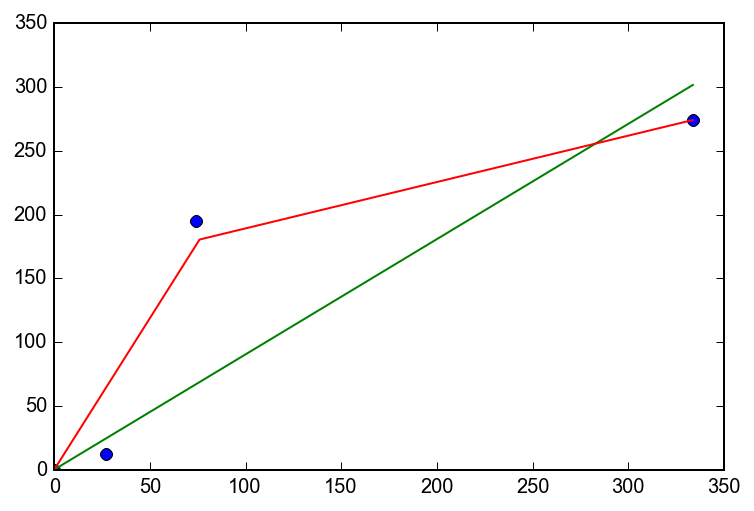

In [17]:
plt.plot(xd, yd, 'o')
plt.plot(lin_x, lin_fit)
plt.plot(lin_x, piece_lin_fit)

plt.show()

In [12]:
piece_lin_fit

array([   0.        ,  180.37793372,  274.10338632])

In [13]:
offset_df = pd.read_csv('../test_data/offsets.csv')
offset_df['offset_m'] = offset_df.offset_in * 200.

t1 = offset_df[offset_df.unit == 'T1']
qa = offset_df[offset_df.unit == 'Qa']
qao = offset_df[offset_df.unit == 'Qao']

#qa['offset_m'] += 200.

t1_age = {'mean': 24., 'sd':8.}
qa_age = {'mean': 50., 'sd':20.}
qao_age = {'mean':100., 'sd':32.}

qao_age['mean'] += 200

T1 = srt.OffsetMarker(age_mean=t1_age['mean'], age_sd=t1_age['sd'],
                      offset_vals=t1.offset_m, offset_probs=t1.rel_prob)

Qa = srt.OffsetMarker(age_mean=qa_age['mean'], age_sd=qa_age['sd'],
                      offset_vals=qa.offset_m, offset_probs=qa.rel_prob)

Qao = srt.OffsetMarker(age_mean=qao_age['mean'], age_sd=qao_age['sd'],
                      offset_vals=qao.offset_m, offset_probs=qao.rel_prob)


offset_list = [T1, Qa, Qao]

In [82]:
def piecewise_linear(x, breakpt, m1, m2):
    return np.piecewise(x, [x < breakpt], [lambda x: m1 * x,
                             lambda x: m2 * x + (m1 * breakpt) - m2 * breakpt])

def piecewise_linear_objective(params, x_data, y_data):
    
    return (y_data - piecewise_linear(x_data, *params))
            
            
def piecewise_linear_objective_2(params, x_data, y_data, weight=0.5):
    
    breakpt, m1, m2 = params
    
    resids = np.array( (y_data - piecewise_linear(x_data, *params)) )
    
    rate_change_penalization = np.sum(np.abs(resids)) * np.abs(m1 - m2) * weight
    
    new_resids = np.append(resids, rate_change_penalization)

    return new_resids

In [83]:
def lls_opt(x_data, y_data):
    breakpt_guess = np.median(x_data)
    m1_guess = x_data.max() / y_data.max()
    m2_guess = x_data.max() / y_data.max()
    init_vals = (breakpt_guess, m1_guess, m2_guess)
    
    #print(np.abs(m1-m2))

    fit, success = leastsq(piecewise_linear_objective_2, init_vals, args=(x_data, y_data))
    
    return fit, success

In [84]:
#%%timeit
lls_opt(xd, yd)[0]

array([ 112.43166544,    1.59498554,    0.42813636])

In [85]:
plin_x = np.array([0, lls_opt(xd, yd)[0][0], xd.max()])

pen_piece_lin_fit = piecewise_linear(plin_x, *lls_opt(xd, yd)[0])

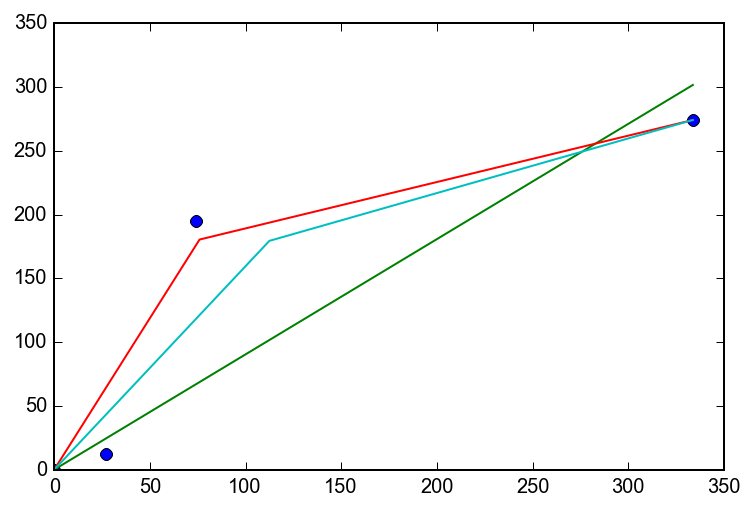

In [86]:
plt.plot(xd, yd, 'o')
plt.plot(lin_x, lin_fit)
plt.plot(lin_x, piece_lin_fit)
plt.plot(plin_x, pen_piece_lin_fit)

plt.show()

In [76]:
%%timeit
srt.piecewise_linear_opt(xd, yd)

100 loops, best of 3: 2.29 ms per loop


In [77]:
%%timeit
srt.piece_lin_opt(xd, yd)

10 loops, best of 3: 43.1 ms per loop
